# Simulating mating

Mating regimes (`xftsim.mate.MatingRegime`) serve two primary functions:

 1. the mates per female the number and offspring count / sex per mating
 2. deciding who mates with whom

 
## Mating and offspring counts

The first (the mates per female the number and offspring count / sex per mating) is determined by the following arguments to the `MatingRegime` constructor:

 - `mates_per_female` - the number of mating partners per female
 - `offspring_per_pair` - the number of offspring per mate pair
 - `female_offspring_per_pair` - the number of female offspring per mate pair
 
Each of this can be constant or variable.

### Variable counts

`xftsim.utils` provides the `VariableCount` class for random counts which include a `draw` method for generating random variates,  an `expectation` property that returns the expected value, and a `nonzero_fraction` property that returns the expected number of nonzero counts. The later is useful for determining, e.g., the fraction of couples expected to produce offspring. 

The simplest `VariableCount` subclass is the `ConstantCount`:

In [1]:
import xftsim as xft

ccount = xft.utils.ConstantCount(2)
ccount.draw(3), ccount.expectation, ccount.nonzero_fraction

(array([2, 2, 2]), 2, 1.0)

Other useful `VariableCount` subclasses are demonstrated below:

In [2]:
pcount = xft.utils.PoissonCount(2)
nbcount = xft.utils.NegativeBinomialCount(2,.5)
ztpcount = xft.utils.ZeroTruncatedPoissonCount(2)
mixcount = xft.utils.MixtureCount(componentCounts=[xft.utils.ConstantCount(0),
                                                   xft.utils.ConstantCount(3)],
                                  mixture_probabilities= [.4,.6])

for count in [pcount, nbcount, ztpcount, mixcount]:
    print(count.expectation, count.nonzero_fraction)

2 0.8646647167633873
2.0 0.75
2.3130352854993315 1
1.7999999999999998 0.6


 
## Who with whom?

The second (who mates with whom) is mostly determined by the `.mate()` method of the `MatingRegime` but also by two boolean flags provided to the `MatingRegime` constructor:

 - `sex_aware` if `True`, enforces a regime where males may only mate with females and vice versa. In many cases, we have no interest in sex effects and it is therefore convenient to set this to `False` to increase the effective population size.
 
 - `exhaustive` if `False` when assigning mates, male mates are sampled with replacement. This too is convenient to set to `False` but should have little impact either way in sufficiently large simulations.
 
The `mate()` methods are specific each `MatingRegime` subclass. Generally speaking, they map haplotype and phenotype arrays to a `MateAssignment` object. 

In what follows, we first introduce simple random mating regimes, then  `MateAssignment` objects, and finally we'll move on to more complex mating regimes.

Throughout, we'll reference the toy dataset below:

In [3]:
import xftsim as xft

demo = xft.sim.DemoSimulation('BGRM')
demo

<DemoSimulation>
Bivariate GCTA with balanced random mating demo

n = 2000; m = 400
Two phenotypes, height and bone mineral denisty (BMD)
assuming bivariate GCTA infinitessimal archtecture
with h2 values set to 0.5 and 0.4 for height and BMD
respectively and a genetic effect correlation of 0.0.

## Random mating

The simplest mating regime is that of random mating.

In [4]:
from xftsim.mate import RandomMatingRegime
from xftsim.utils import ConstantCount, PoissonCount

rm_regime = RandomMatingRegime(offspring_per_pair = ConstantCount(2),
                                mates_per_female = ConstantCount(1),
                                female_offspring_per_pair = 'balanced',
                                sex_aware = False,
                                exhaustive = True)
                                        

Setting `female_offspring_per_pair` to `"balanced"` rather than a `VariableCount` object will result in a equal number of male and female offspring. 

It is sometimes useful to predict how the population size will change across generations. The `MatingRegime.population_growth_factor` property reveals the expected multiplicative change in population size each generation.

As we specified `rm_regime` such that each female is paired with exactly one male and each mating will produce exactly one offspring, we expect constant population size:

In [5]:
rm_regime.population_growth_factor

1.0

Of course, this is not always the case, as we demonstrate below:

In [6]:
rm_regime2 = RandomMatingRegime(offspring_per_pair = PoissonCount(2.2),
                                mates_per_female = PoissonCount(1.1),
                                female_offspring_per_pair = 'balanced',
                                sex_aware = False,
                                exhaustive = True)
              
rm_regime2.population_growth_factor

1.2100000000000002

## Mate assignments

Mating regime objects map haplotypes and phenotypes to a `MateAssignment` object, which stores information about who mates with whom and the offspring such matings produce:

:::{note}

In practice, users will rarely call `MateAssignment.mate()` directly as this occurs automatically when running a simulation.

:::


In [7]:
mate_assignment = rm_regime.mate(haplotypes=demo.haplotypes,
                                 phenotypes=demo.phenotypes)

:::{note}

Since the mating regime we're using is random, the only information the `mate` method uses from either the haplotypes or phenotypes would be the associated `index.SampleIndex` object.

:::

Two useful perspectives for viewing a `MateAssignment` are the `mating_frame`, which is indexed by couple, and the `reproduction_frame`, which is indexed by offspring:

In [8]:
mate_assignment.get_mating_frame()

,maternal_sample,maternal_iid,maternal_fid,maternal_sex,paternal_sample,paternal_iid,paternal_fid,paternal_sex,n_offspring,n_female_spring
0,0..1_1980.1_990,1_1980,1_990,1,0..1_321.1_160,1_321,1_160,1,2,0
1,0..1_782.1_391,1_782,1_391,0,0..1_1766.1_883,1_1766,1_883,0,2,1
2,0..1_1899.1_949,1_1899,1_949,1,0..1_772.1_386,1_772,1_386,0,2,2
3,0..1_229.1_114,1_229,1_114,1,0..1_1129.1_564,1_1129,1_564,1,2,1
4,0..1_1260.1_630,1_1260,1_630,1,0..1_1745.1_872,1_1745,1_872,1,2,1
...,...,...,...,...,...,...,...,...,...,...
995,0..1_912.1_456,1_912,1_456,0,0..1_430.1_215,1_430,1_215,1,2,2
996,0..1_1892.1_946,1_1892,1_946,1,0..1_838.1_419,1_838,1_419,1,2,0
997,0..1_642.1_321,1_642,1_321,0,0..1_260.1_130,1_260,1_130,0,2,2
998,0..1_75.1_37,1_75,1_37,1,0..1_1063.1_531,1_1063,1_531,1,2,1


In [9]:
mate_assignment.get_reproduction_frame()

,iid,fid,sex,maternal_sample,maternal_iid,maternal_fid,maternal_sex,paternal_sample,paternal_iid,paternal_fid,paternal_sex
sample,,,,,,,,,,,
0..2_0.2_0,2_0,2_0,1,0..1_1980.1_990,1_1980,1_990,1,0..1_321.1_160,1_321,1_160,1
0..2_1.2_0,2_1,2_0,1,0..1_1980.1_990,1_1980,1_990,1,0..1_321.1_160,1_321,1_160,1
0..2_2.2_1,2_2,2_1,0,0..1_782.1_391,1_782,1_391,0,0..1_1766.1_883,1_1766,1_883,0
0..2_3.2_1,2_3,2_1,1,0..1_782.1_391,1_782,1_391,0,0..1_1766.1_883,1_1766,1_883,0
0..2_4.2_2,2_4,2_2,0,0..1_1899.1_949,1_1899,1_949,1,0..1_772.1_386,1_772,1_386,0
...,...,...,...,...,...,...,...,...,...,...,...
0..2_1995.2_997,2_1995,2_997,0,0..1_642.1_321,1_642,1_321,0,0..1_260.1_130,1_260,1_130,0
0..2_1996.2_998,2_1996,2_998,0,0..1_75.1_37,1_75,1_37,1,0..1_1063.1_531,1_1063,1_531,1
0..2_1997.2_998,2_1997,2_998,1,0..1_75.1_37,1_75,1_37,1,0..1_1063.1_531,1_1063,1_531,1


## Nonrandom mating regimes


:::{warning}

It will be challenging to to understand this information if you haven't read [the tutorial on indexing](./indexing.ipynb)! Specifically, understanding `xftsim.index.ComponentIndex` is essential.

:::

As `xftsim` mating regimes are privy to haplotypes and phenotypes, the can be very general. Here we present a few commonly used regimes.

### Linear assortative mating

By "linear assortative mating", we refer to mating mediated through a linear combination of phenotypic components. An exchangeable linear regime is provided by `xft.mate.LinearAssortativeMatingRegime`. Concretely, assume we want an exchangeable regime for $k$ phenotypes with cross-mate correlations fixed at `r`. That is, given female and male phenotypes $Y,\tilde{Y}\in R^{n\times k}$, respectively, this regime will generate a mating permutation $P$

such that the empirical correlation is
$$\text{corr}(Y,P\tilde{Y})\approx r\cdot1_{k\times k}.$$


### Univariate primary phenotypic assortment

We can implement univariate assortative mating mediated through a single phenotype via `LinearAssortativeMatingRegime`. Below we do this for height, setting the cross-mate correlation to 0.5. We iterate for a single generation and then observe the sample mating statstics:

In [10]:
from xftsim.mate import LinearAssortativeMatingRegime

reg_pp = LinearAssortativeMatingRegime(r=.5,
    component_index=xft.index.ComponentIndex.from_product(phenotype_name='height', 
                                                          component_name='phenotype'))

demo_pp = xft.sim.DemoSimulation()
demo_pp.mating_regime = reg_pp
demo_pp.run(1)
xmate_corr = demo_pp.results['mating_statistics']['mate_correlations']
xmate_corr.iloc[:xmate_corr.shape[0]//2,xmate_corr.shape[0]//2:]

component,height.additiveGenetic.father,BMD.additiveGenetic.father,height.additiveNoise.father,BMD.additiveNoise.father,height.phenotype.father,BMD.phenotype.father
component,,,,,,
height.additiveGenetic.mother,0.268342,-0.008584,0.285039,-0.048256,0.397498,-0.042764
BMD.additiveGenetic.mother,0.008731,-0.046509,-0.004701,0.030176,0.002762,-0.003530
height.additiveNoise.mother,0.213312,0.011146,0.245511,0.047010,0.329757,0.043285
BMD.additiveNoise.mother,0.025006,0.073521,0.004836,-0.003132,0.021229,0.040452
height.phenotype.mother,0.345829,0.001849,0.380946,-0.000849,0.522178,0.000415
BMD.phenotype.mother,0.024631,0.029059,0.000926,0.015699,0.018117,0.029240


### Univariate social / genetic homogamy

Social or genetic homogamy can be modeled by specifying that mating operates only on the non-heritable or heritable components respectively:


In [11]:
from xftsim.mate import LinearAssortativeMatingRegime

reg_social = LinearAssortativeMatingRegime(r=.5,
    component_index=xft.index.ComponentIndex.from_product(phenotype_name='height', 
                                                          component_name='additiveNoise'))

reg_genetic = LinearAssortativeMatingRegime(r=.5,
    component_index=xft.index.ComponentIndex.from_product(phenotype_name='height', 
                                                          component_name='additiveGenetic'))


demo_soc = xft.sim.DemoSimulation(); demo_gen = xft.sim.DemoSimulation()
demo_soc.mating_regime = reg_social; demo_gen.mating_regime = reg_genetic; 
demo_soc.run(1); demo_gen.run(1)
xmate_corr_soc = demo_soc.results['mating_statistics']['mate_correlations']
xmate_corr_soc.iloc[:xmate_corr_soc.shape[0]//2,xmate_corr_soc.shape[0]//2:]

component,height.additiveGenetic.father,BMD.additiveGenetic.father,height.additiveNoise.father,BMD.additiveNoise.father,height.phenotype.father,BMD.phenotype.father
component,,,,,,
height.additiveGenetic.mother,-0.075997,0.020729,-0.022070,-0.009579,-0.068682,0.006065
BMD.additiveGenetic.mother,-0.034681,0.001651,-0.049497,-0.010576,-0.058171,-0.006805
height.additiveNoise.mother,0.048020,0.039968,0.497350,-0.017413,0.372348,0.012479
BMD.additiveNoise.mother,0.024209,-0.048029,-0.028814,0.026596,-0.002513,-0.010783
height.phenotype.mother,-0.020428,0.043707,0.341454,-0.019438,0.217930,0.013352
BMD.phenotype.mother,-0.003607,-0.034945,-0.052617,0.013294,-0.038352,-0.012345


In [12]:
xmate_corr_gen = demo_gen.results['mating_statistics']['mate_correlations']
xmate_corr_gen.iloc[:xmate_corr_gen.shape[0]//2,xmate_corr_gen.shape[0]//2:]

component,height.additiveGenetic.father,BMD.additiveGenetic.father,height.additiveNoise.father,BMD.additiveNoise.father,height.phenotype.father,BMD.phenotype.father
component,,,,,,
height.additiveGenetic.mother,0.529864,0.001163,0.063315,0.035746,0.415366,0.028550
BMD.additiveGenetic.mother,-0.004869,-0.007057,-0.030289,0.034901,-0.024318,0.022398
height.additiveNoise.mother,-0.027741,-0.006710,0.006791,0.031207,-0.014773,0.019760
BMD.additiveNoise.mother,-0.004571,-0.025001,0.045424,0.011315,0.028142,-0.007923
height.phenotype.mother,0.365798,-0.003683,0.050528,0.046995,0.291459,0.034050
BMD.phenotype.mother,-0.006635,-0.024104,0.016955,0.030649,0.007047,0.007698


### Exchangeable bivariate phenotypic assortment

Exchangeable bivariate phenotypic assortment is also easily accommodated in this framework. Here we implement such a regime for $r$=.1 across height and bone mineral density (BMD):

In [13]:
reg_biv = LinearAssortativeMatingRegime(r=.1,
    component_index=xft.index.ComponentIndex.from_product(phenotype_name=['height','BMD'], 
                                                          component_name='phenotype'))

demo_biv = xft.sim.DemoSimulation()
demo_biv.mating_regime = reg_biv
demo_biv.run(1)
xmate_corr = demo_biv.results['mating_statistics']['mate_correlations']
xmate_corr.iloc[:xmate_corr.shape[0]//2,xmate_corr.shape[0]//2:]

component,height.additiveGenetic.father,BMD.additiveGenetic.father,height.additiveNoise.father,BMD.additiveNoise.father,height.phenotype.father,BMD.phenotype.father
component,,,,,,
height.additiveGenetic.mother,0.042121,0.007638,0.063715,0.064258,0.076388,0.054666
BMD.additiveGenetic.mother,0.011518,-0.000970,0.025269,0.016718,0.026438,0.012362
height.additiveNoise.mother,-0.005662,0.005028,0.117724,0.087100,0.079050,0.070748
BMD.additiveNoise.mother,0.023836,0.056490,0.033903,0.063639,0.041705,0.084921
height.phenotype.mother,0.025256,0.008798,0.126190,0.105230,0.108031,0.087188
BMD.phenotype.mother,0.026047,0.044510,0.042460,0.060993,0.049401,0.075330


## Generalized assortive mating

We can also model general assortment to achieve an arbitrary cross-mate cross-correlation matrix across a set of $K$ phenotypes. In `xftsim` this is done by solving an equivalent corresponding combinatorial optimization problem. This problem (the quadratic assignment problem (QAP)) is NP-hard and requires the use of the closed-source [LocalSolver](https://www.localsolver.com) software and corresponding Python library.

:::{warning}

The LocalSolver dependences must be installed separately. Additionally, a license is required to run the software. Academic licenses are available from the [LocalSolver](https://www.localsolver.com) website.

:::


Suppose we want to model complex assortment across BMI, height, years of education, and smoking behaviors. In the UK Biobank, these traits have approximately the following cross-mate cross-correlation structure (see fig 1, [Border et al. 2022](https://doi.org/10.1126/science.abo2059)):

    
$$\begin{array}{c|cccc}
 & \text{BMI} & \text{height} & \text{edu} & \text{smoke}\\
\hline \text{BMI} & +.26\\
\text{height} & -.05 & +.24\\
\text{edu} & -.11 & +.10 & +.33\\
\text{smoke} & +.08 & -.02 & -.06 & +.19
\end{array}
$$

To model this in `xftsim` we can use `GeneralAssortativeMatingRegime`:

In [8]:
import xftsim as xft
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 240 ## better looking plots
plt.rcParams['figure.figsize'] = [6.,4.]
xft.config.print_durations_threshold = 1. ## reduce output verbosity

cind = xft.index.ComponentIndex.from_product(['bmi','height','edu','smoke'], 
                                             'phenotype')

xmatecorr = np.array([[.26,-.05,-.11, .08],
                      [-.05,.24,.10,-.02],
                      [-.11,.10,.33,-.06],
                      [.08,-.02,-.06,.19]])



mate_reg = xft.mate.GeneralAssortativeMatingRegime(component_index=cind,
    cross_corr=xmatecorr,
    control=dict(nb_threads=8,
                 time_limit = 120,
                 time_between_displays=5))

:::{tip}

Solving the combinatorial optimization required for arbitrary cross-trait assortative mating can be computationally intensive. Finding the optimal solution is NP-hard, but we can do pretty well by iterating for a fixed amount of time. This time limit (specified above by the `time_limit` key in the `control` dictionary) is sensitive to both the population size and number of phenotypes under assortment. We suggest experimentation, comparing the realized cross-mate correlation matrix to the target matrix. Further, it is often faster to batch mating for computational efficiency (see the section on batched regimes below).

:::


To demonstrate this regime, we will assume an independent infinitessimal model with the following (arbitrary) panmictic heritabilities: $h^2_\text{BMI} = .4$, $h^2_\text{height} = .6$, $h^2_\text{edu} = .3$, $h^2_\text{smoke} = .25$ and first specify the corresponding phenogenetic architecture:



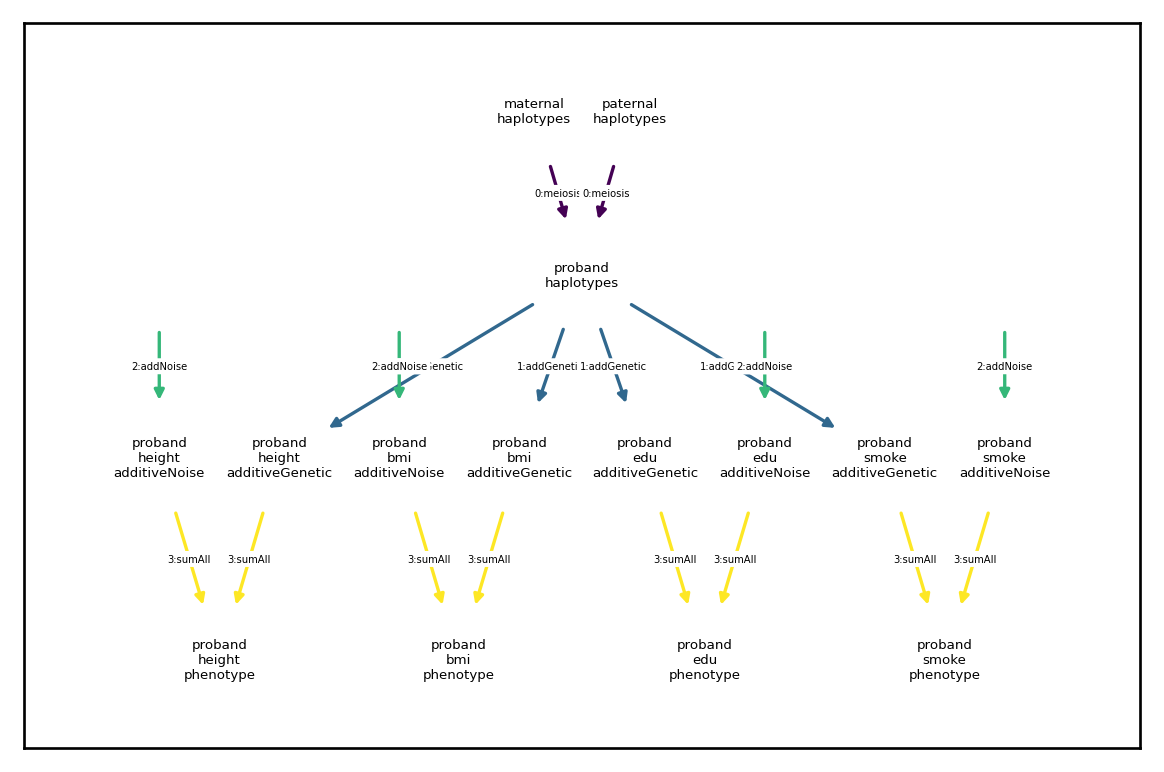

In [9]:
n=2000; m=800
h2=np.array([.4, .6, .3, .25])

# founder haplotypes
haplotypes = xft.founders.founder_haplotypes_uniform_AFs(n=n,m=m)
# recombination map
rmap = xft.reproduce.RecombinationMap.constant_map_from_haplotypes(p=.1,
                                                                   haplotypes=haplotypes)
# additive phenogenetic architecture
arch = xft.arch.GCTA_Architecture(h2=h2, 
                                  phenotype_name=['bmi','height','edu','smoke'],
                                  haplotypes=haplotypes)
# simulation object
sim = xft.sim.Simulation(founder_haplotypes=haplotypes, 
                         recombination_map=rmap, 
                         architecture=arch, 
                         mating_regime = mate_reg,
                         statistics= [xft.stats.SampleStatistics(),
                                      xft.stats.MatingStatistics()])
arch.draw_dependency_graph(font_size=4)

In [6]:
sim.run(1)

    2.35 mks in increment_generation
    6.40 mks in reproduce
  172.60 ms in compute_phenotypes
Push initial solution 100%
Model:  expressions = 6006012, decisions = 1, constraints = 1, objectives = 1
Param:  time limit = 120 sec, no iteration limit, nb threads = 8
        time between displays = 5

[objective direction ]:     minimize

[  0 sec,       0 itr]:     0.904413
[ optimality gap     ]:       > 100%
[  5 sec,      88 itr]:     0.183807
[ 10 sec,     182 itr]:     0.144635
[ 15 sec,     278 itr]:      0.11705
[ 20 sec,     367 itr]:    0.0850189
[ 25 sec,     429 itr]:    0.0621292
[ 30 sec,     517 itr]:    0.0507904
[ 35 sec,     604 itr]:    0.0432865
[ 40 sec,     694 itr]:    0.0361864
[ 45 sec,     811 itr]:    0.0276867
[ 50 sec,     893 itr]:    0.0217341
[ optimality gap     ]:       > 100%
[ 55 sec,     979 itr]:    0.0171043
[ 60 sec,    1067 itr]:    0.0147058
[ 65 sec,    1165 itr]:    0.0108805
[ 70 sec,    1261 itr]:    0.0101373
[ 75 sec,    1336 itr]:   0.009

Comparing our realized mating structure to the target shows that the optimzation completed successfully:

In [5]:
sim.results['mating_statistics']['mate_correlations'].iloc[:4,4:]

component,bmi.phenotype.father,height.phenotype.father,edu.phenotype.father,smoke.phenotype.father
component,,,,
bmi.phenotype.mother,0.259063,-0.050205,-0.108674,0.076731
height.phenotype.mother,-0.045843,0.243643,0.100098,-0.022487
edu.phenotype.mother,-0.106854,0.093305,0.326693,-0.057785
smoke.phenotype.mother,0.081431,-0.023318,-0.059520,0.190134


In [4]:
xmatecorr

array([[ 0.26, -0.05, -0.11,  0.08],
       [-0.05,  0.24,  0.1 , -0.02],
       [-0.11,  0.1 ,  0.33, -0.06],
       [ 0.08, -0.02, -0.06,  0.19]])

## Batched mating regimes

A `xft.mate.BatchedMatingRegime` simply takes an existing mating regime and applies in to subsets of the data. By default, it will split the sample into equal random subsamples no larger than `max_batch_size`. This can be very useful in combination with `xft.mate.GeneralAssortativeMatingRegime` as it's often faster to solve multiple smaller optimization problems than one large problem. Here we achieve similar results to the previous example by optimizing for 30 seconds (twice) in each half of a random split of the data as opposed to 120 seconds in the full sample.


In [11]:
mate_batch = xft.mate.GeneralAssortativeMatingRegime(component_index=cind,
    cross_corr=xmatecorr,
    control=dict(nb_threads=8,
                 time_limit = 30,
                 time_between_displays=5))

batched_regime = xft.mate.BatchedMatingRegime(mate_batch, 
                                              max_batch_size=1000)

In [13]:
sim = xft.sim.Simulation(founder_haplotypes=haplotypes, 
                         recombination_map=rmap, 
                         architecture=arch, 
                         mating_regime = batched_regime,
                         statistics= [xft.stats.SampleStatistics(),
                                      xft.stats.MatingStatistics()])
sim.run(1)

    2.91 mks in increment_generation
    2.78 mks in reproduce
   66.91 ms in compute_phenotypes
Push initial solution 100%
Model:  expressions = 1503012, decisions = 1, constraints = 1, objectives = 1
Param:  time limit = 30 sec, no iteration limit, nb threads = 8
        time between displays = 5

[objective direction ]:     minimize

[  0 sec,       0 itr]:     0.849955
[ optimality gap     ]:       > 100%
[  5 sec,     502 itr]:    0.0316502
[ 10 sec,    1019 itr]:   0.00943589
[ 15 sec,    1545 itr]:   0.00598421
[ 20 sec,    2181 itr]:   0.00537489
[ 25 sec,    2756 itr]:   0.00524854
[ 30 sec,    3412 itr]:    0.0051854
[ 30 sec,    3412 itr]:    0.0051854
[ optimality gap     ]:       > 100%

3412 iterations performed in 30 seconds

Feasible solution: 
  obj    =    0.0051854
  gap    =       > 100%
  bounds =     -32.7763
Push initial solution 100%
Model:  expressions = 1503012, decisions = 1, constraints = 1, objectives = 1
Param:  time limit = 30 sec, no iteration limit, nb 

In [14]:
sim.results['mating_statistics']['mate_correlations'].iloc[:4,4:]

component,bmi.phenotype.father,height.phenotype.father,edu.phenotype.father,smoke.phenotype.father
component,,,,
bmi.phenotype.mother,0.259715,-0.050911,-0.107914,0.077503
height.phenotype.mother,-0.047922,0.239276,0.099072,-0.016085
edu.phenotype.mother,-0.107737,0.096561,0.325611,-0.060520
smoke.phenotype.mother,0.080135,-0.021780,-0.057260,0.190545


In [15]:
xmatecorr

array([[ 0.26, -0.05, -0.11,  0.08],
       [-0.05,  0.24,  0.1 , -0.02],
       [-0.11,  0.1 ,  0.33, -0.06],
       [ 0.08, -0.02, -0.06,  0.19]])

Again, we have satisfactorily reproduced the target cross-mate correlation structure. This batched approach is likely the only practical way to proceed for generalized assortative mating in larger samples.